In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Jun  6 09:45:52 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.106.00   Driver Version: 460.106.00   CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A30                 On   | 00000000:03:00.0 Off |                    0 |
| N/A   43C    P0    53W / 165W |      0MiB / 24258MiB |     62%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
import glob
import pandas as pd
import tensorflow_io as tfio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import pathlib
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [8]:
def train_model():
  data_dir = pathlib.Path('content/img_RGB')

  batch_size = 64
  img_height = 128
  img_width = 128

  IMG_SHAPE = (img_height, img_width) + (3,)

  train_ds = tf.keras.utils.image_dataset_from_directory(
    pathlib.Path('content/img_RGB'),
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)
  
  val_ds = tf.keras.utils.image_dataset_from_directory(
    pathlib.Path('content/img_RGB'),
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

  class_names = train_ds.class_names

  AUTOTUNE = tf.data.AUTOTUNE
  num_classes = len(class_names)

  train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
  val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

  data_augmentation = Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
  ])

  # Create the base model from the pre-trained model
  base_model_1 = tf.keras.applications.DenseNet201(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')
  base_model_1.trainable = False
    
    # Create the base model from the pre-trained model
  base_model_xception = tf.keras.applications.xception.Xception(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')
  base_model_xception.trainable = False  

  inputs = tf.keras.Input(shape=(128, 128, 3))
  x = data_augmentation(inputs)

  x1 = tf.keras.layers.Rescaling(scale=1./255)(x)
  x1 = tfio.experimental.color.rgb_to_xyz(x1)
  x1 = base_model_1(x1)
  x1 = tf.keras.layers.MaxPooling2D()(x1)
  x1 = tf.keras.layers.Dropout(0.2)(x1)
  x1 = tf.keras.layers.Flatten()(x1)
    
  x2 = tf.keras.applications.densenet.preprocess_input(x)  
  x2 = base_model_1(x2)  
  x2 = tf.keras.layers.MaxPooling2D()(x2)
  x2 = tf.keras.layers.Dropout(0.2)(x2)
  x2 = tf.keras.layers.Flatten()(x2)

  x3 = tf.keras.layers.Rescaling(scale=1./255)(x)
  x3 = tfio.experimental.color.rgb_to_xyz(x3)
  x3 = base_model_xception(x3)
  x3 = tf.keras.layers.MaxPooling2D()(x3)
  x3 = tf.keras.layers.Dropout(0.2)(x3)
  x3 = tf.keras.layers.Flatten()(x3)
    
  x4 = tf.keras.applications.xception.preprocess_input(x)  
  x4 = base_model_xception(x4)  
  x4 = tf.keras.layers.MaxPooling2D()(x4)
  x4 = tf.keras.layers.Dropout(0.2)(x4)
  x4 = tf.keras.layers.Flatten()(x4)
    
  concatted = tf.keras.layers.Concatenate()([x1, x2, x3, x4])

  concatted = tf.keras.layers.Dense(512, activation='relu')(concatted)
  concatted = tf.keras.layers.Dropout(0.2)(concatted)
  concatted = tf.keras.layers.Dense(128, activation='relu')(concatted)
  outputs = tf.keras.layers.Dense(5)(concatted)
  model = tf.keras.Model(inputs, outputs)

  base_learning_rate = 0.0005

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

  epochs=100
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
  )

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(16, 6))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()
    
  return {'acc': acc, 'val_acc': val_acc, 'loss': loss, 'val_loss': val_loss}

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Epoch 1/100
360/360 [==============================] - 72s 138ms/step - loss: 0.5438 - accuracy: 0.7804 - val_loss: 0.3852 - val_accuracy: 0.8517
Epoch 2/100
360/360 [==============================] - 39s 108ms/step - loss: 0.4074 - accuracy: 0.8312 - val_loss: 0.3683 - val_accuracy: 0.8491
Epoch 3/100
360/360 [==============================] - 38s 106ms/step - loss: 0.3756 - accuracy: 0.8424 - val_loss: 0.3398 - val_accuracy: 0.8560
Epoch 4/100
360/360 [==============================] - 39s 107ms/step - loss: 0.3572 - accuracy: 0.8535 - val_loss: 0.2970 - val_accuracy: 0.8854
Epoch 5/100
360/360 [==============================] - 39s 108ms/step - loss: 0.3434 - accuracy: 0.8580 - val_loss: 0.3293 - val_accuracy: 0.8750
Epoch 6/100
360/360 [==============================] - 38s 105ms/step - loss: 0.3362 - accuracy: 0.8646 - val_loss: 0.316

Epoch 56/100
360/360 [==============================] - 38s 105ms/step - loss: 0.2164 - accuracy: 0.9132 - val_loss: 0.2450 - val_accuracy: 0.9064
Epoch 57/100
360/360 [==============================] - 38s 106ms/step - loss: 0.2122 - accuracy: 0.9165 - val_loss: 0.2468 - val_accuracy: 0.9024
Epoch 58/100
360/360 [==============================] - 38s 105ms/step - loss: 0.2124 - accuracy: 0.9166 - val_loss: 0.2269 - val_accuracy: 0.9149
Epoch 59/100
360/360 [==============================] - 38s 106ms/step - loss: 0.2162 - accuracy: 0.9153 - val_loss: 0.2211 - val_accuracy: 0.9139
Epoch 60/100
360/360 [==============================] - 38s 105ms/step - loss: 0.2088 - accuracy: 0.9189 - val_loss: 0.2380 - val_accuracy: 0.9090
Epoch 61/100
360/360 [==============================] - 38s 104ms/step - loss: 0.2134 - accuracy: 0.9148 - val_loss: 0.2250 - val_accuracy: 0.9146
Epoch 62/100
360/360 [==============================] - 38s 107ms/step - loss: 0.2060 - accuracy: 0.9187 - val_loss: 0

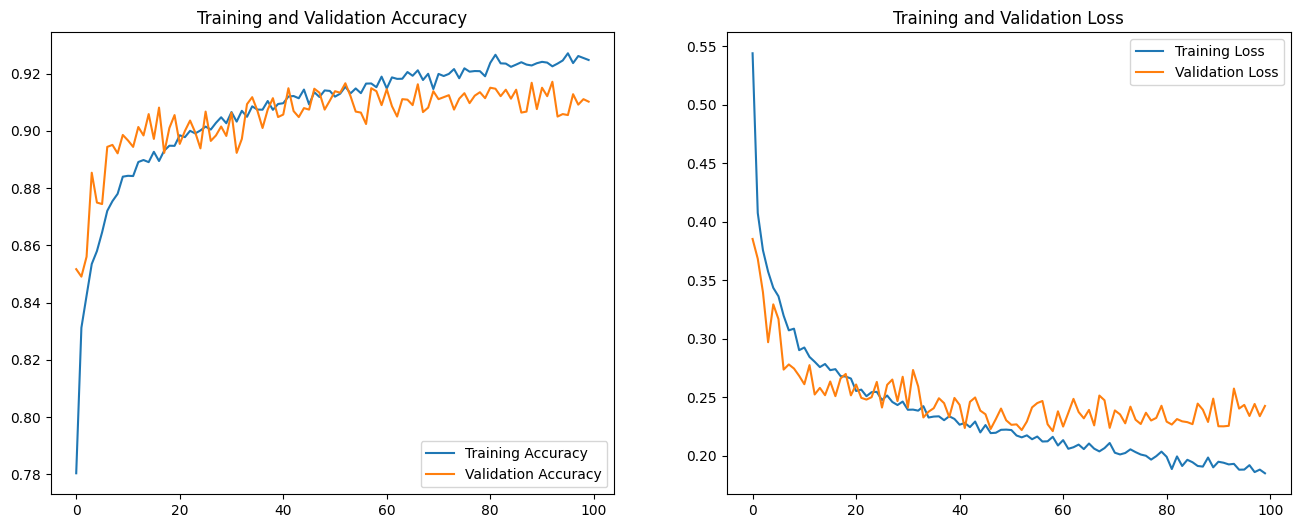

In [4]:
# DenseNet201 XYZ* + DenseNet201 RGB
conf1_mix = train_model()

In [6]:
np.max(conf1_mix['val_acc'])

0.9171587228775024

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Epoch 1/100
360/360 [==============================] - 87s 180ms/step - loss: 0.5204 - accuracy: 0.8044 - val_loss: 0.3375 - val_accuracy: 0.8753
Epoch 2/100
360/360 [==============================] - 58s 162ms/step - loss: 0.3740 - accuracy: 0.8498 - val_loss: 0.3515 - val_accuracy: 0.8515
Epoch 3/100
360/360 [==============================] - 58s 160ms/step - loss: 0.3458 - accuracy: 0.8615 - val_loss: 0.3143 - val_accuracy: 0.8718
Epoch 4/100
360/360 [==============================] - 58s 160ms/step - loss: 0.3272 - accuracy: 0.8669 - val_loss: 0.2887 - val_accuracy: 0.8843
Epoch 5/100
360/360 [==============================] - 58s 161ms/step - loss: 0.3107 - accuracy: 0.8751 - val_loss: 0.2712 - val_accuracy: 0.8923
Epoch 6/100
360/360 [==============================] - 59s 163ms/step - loss: 0.2995 - accuracy: 0.8810 - val_loss: 0.274

Epoch 56/100
360/360 [==============================] - 58s 162ms/step - loss: 0.1753 - accuracy: 0.9328 - val_loss: 0.2319 - val_accuracy: 0.9126
Epoch 57/100
360/360 [==============================] - 59s 163ms/step - loss: 0.1725 - accuracy: 0.9311 - val_loss: 0.2285 - val_accuracy: 0.9149
Epoch 58/100
360/360 [==============================] - 58s 162ms/step - loss: 0.1765 - accuracy: 0.9295 - val_loss: 0.2305 - val_accuracy: 0.9144
Epoch 59/100
360/360 [==============================] - 59s 163ms/step - loss: 0.1714 - accuracy: 0.9318 - val_loss: 0.2254 - val_accuracy: 0.9161
Epoch 60/100
360/360 [==============================] - 58s 162ms/step - loss: 0.1724 - accuracy: 0.9325 - val_loss: 0.2156 - val_accuracy: 0.9185
Epoch 61/100
360/360 [==============================] - 58s 161ms/step - loss: 0.1711 - accuracy: 0.9319 - val_loss: 0.2168 - val_accuracy: 0.9213
Epoch 62/100
360/360 [==============================] - 58s 162ms/step - loss: 0.1742 - accuracy: 0.9312 - val_loss: 0

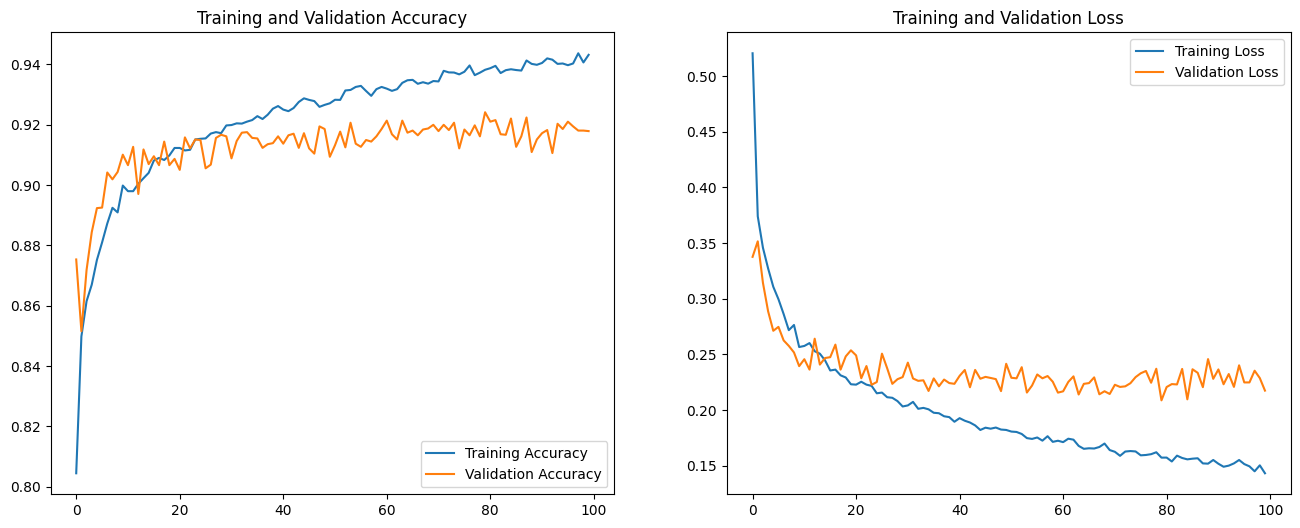

In [10]:
conf2_mix = train_model()

In [11]:
np.max(conf2_mix['val_acc'])

0.9241055846214294

In [12]:
!mkdir ensembles_mix
pd.DataFrame(conf1_mix).to_csv("ensembles_mix/conf1_mix.csv", index=False)
pd.DataFrame(conf2_mix).to_csv("ensembles_mix/conf2_mix.csv", index=False)